# K-Nearest Neighbors Classifier
---

### Objectives:

- Use K-Nearest neighbors to classify data

- Apply KNN classifier on a real world data set

### Installs:

In [0]:
%%capture
%pip install numpy==2.4.0
%pip install pandas==2.3.3
%pip install scikit-learn==1.8.0
%pip install matplotlib==3.10.8
%pip install seaborn==0.13.0

In [0]:
# Command to restart the kernel and update the installed libraries
%restart_python

### Imports:

In [0]:
# Data Analize and Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data Modeling / Model Linear / Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

# Warnings
import warnings
warnings.filterwarnings('ignore')

### Load the data

In [0]:
df = pd.read_csv('./data/teleCust1000t.csv')

### Verify successful load with some randomly selected records


In [0]:
df.sample(9)

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
185,3,24,26,0,2,32.0,3,2,0.0,0,3,1
286,1,38,37,1,1,52.0,1,20,0.0,1,4,4
108,1,13,54,0,2,31.0,4,2,0.0,0,1,1
259,3,7,27,0,5,31.0,3,4,0.0,0,5,4
886,2,16,49,0,17,41.0,2,5,0.0,0,1,4
22,3,53,33,0,10,101.0,5,4,0.0,1,2,4
866,2,33,40,1,14,19.0,3,5,0.0,0,2,1
643,3,3,64,0,3,9.0,2,6,1.0,0,1,1
483,1,7,23,0,3,27.0,2,1,0.0,1,3,1



### Understand the data

---

#### Scenario

A telecommunications provider has segmented its customer base by service usage patterns into four distinct groups. The main business goal is to leverage demographic data to predict group membership for prospective customers. By accurately classifying new customers, the company can customize offers and marketing strategies for each individual, thereby maximizing conversion rates and customer value.

#### Loading Telecommunications Data

The dataset contains demographic and service usage information for a set of customers. Each row represents a unique customer profile, linking their personal attributes to their subscribed service category.

#### About the Dataset

This is a classification problem where the objective is to build a model (specifically using **K-Nearest Neighbors**) to predict the class of a new or unknown case based on predefined labels.

The dataset structure includes:

* **Demographic Features**: The independent variables used to predict the customer profile. These include `region`, `tenure`, `age`, `marital` status, `address`, `income`, `ed` (education), `employ` (employment years), `retire` (retirement status), `gender`, and `reside` (number of people in household).
* **Target Variable (custcat)**: The dependent variable indicating the customer's service group. It has four possible values:

1. **Basic Service**
2. **E-Service**
3. **Plus Service**
4. **Total Service**

### Explore the data
First, consider a statistical summary of the data.

In [0]:
df.describe()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.0220,35.526000,41.684000,0.495000,11.551000,77.535000,2.671000,10.987000,0.047000,0.517000,2.331000,2.487000
std,0.8162,21.359812,12.558816,0.500225,10.086681,107.044165,1.222397,10.082087,0.211745,0.499961,1.435793,1.120306
min,1.0000,1.000000,18.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.0000,17.000000,32.000000,0.000000,3.000000,29.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000
50%,2.0000,34.000000,40.000000,0.000000,9.000000,47.000000,3.000000,8.000000,0.000000,1.000000,2.000000,3.000000
75%,3.0000,54.000000,51.000000,1.000000,18.000000,83.000000,4.000000,17.000000,0.000000,1.000000,3.000000,3.000000
max,3.0000,72.000000,77.000000,1.000000,55.000000,1668.000000,5.000000,47.000000,1.000000,1.000000,8.000000,4.000000


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   region   1000 non-null   int64  
 1   tenure   1000 non-null   int64  
 2   age      1000 non-null   int64  
 3   marital  1000 non-null   int64  
 4   address  1000 non-null   int64  
 5   income   1000 non-null   float64
 6   ed       1000 non-null   int64  
 7   employ   1000 non-null   int64  
 8   retire   1000 non-null   float64
 9   gender   1000 non-null   int64  
 10  reside   1000 non-null   int64  
 11  custcat  1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB


### Check distribution of target variable

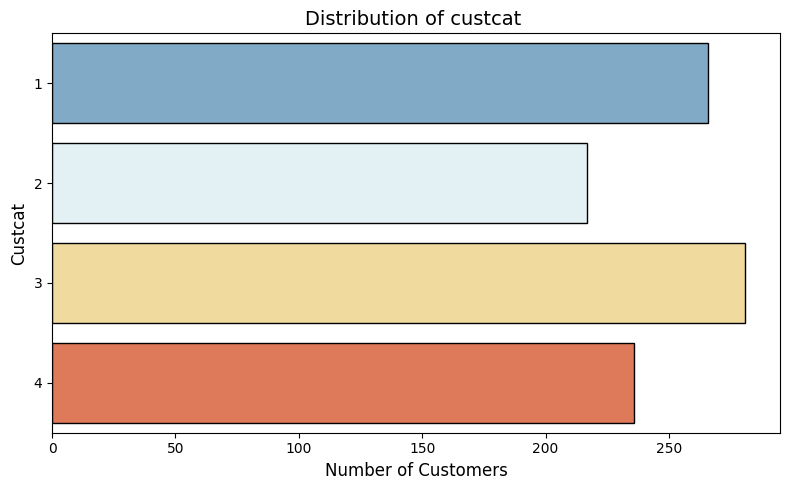

In [0]:
level_order = [
    1, 
    2, 
    3, 
    4,     
]

# Figure
plt.figure(figsize = (8, 5))

# Count Plot
ax = sns.countplot(
    y = 'custcat',
    data = df,
    order = level_order,
    edgecolor = 'black',
    palette = 'RdYlBu_r',
)

plt.title('Distribution of custcat ', fontsize = 14)
plt.xlabel('Number of Customers', fontsize = 12)
plt.ylabel('Custcat', fontsize = 12)

plt.tight_layout()
plt.show()

In [0]:
df['custcat'].value_counts()

custcat
3    281
1    266
4    236
2    217
Name: count, dtype: int64

We can say that we have records of 281 customers who opt for Plus Services, 266 for Basic-services, 236 for Total Services, and 217 for E-Services. It can thus be seen that the data set is mostly balanced between the different classes and requires no special means of accounting for class bias.

### Checking the correlations between the variables

In [0]:
df.corr()['custcat'].abs().sort_values(ascending = False)

custcat    1.000000
ed         0.193864
tenure     0.166691
income     0.134525
employ     0.110011
marital    0.083836
reside     0.082022
address    0.067913
age        0.056909
region     0.023771
retire     0.008908
gender     0.004966
Name: custcat, dtype: float64

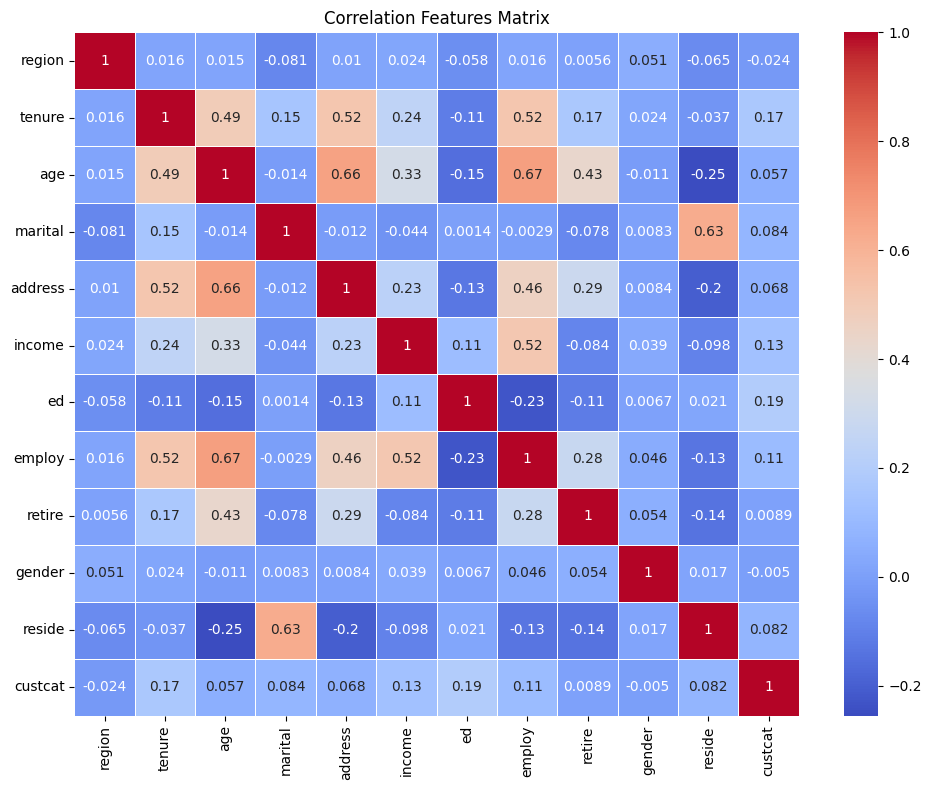

In [0]:
plt.rc('font', size = 10)
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm', ax = ax, linewidths = 0.5)
ax.set_title('Correlation Features Matrix')
plt.tight_layout()
plt.show()

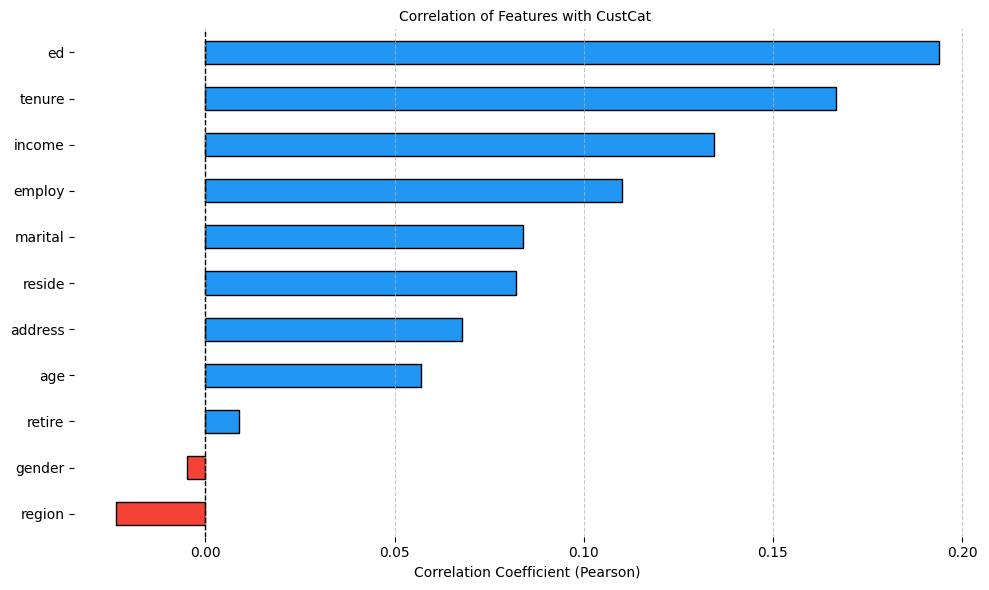

In [0]:
# Collecting data
correlation_values = df.corr()['custcat']

if 'custcat' in  correlation_values.index:
    plot_data = correlation_values.drop('custcat').sort_values()

else:
    plot_data = correlation_values.sort_values()


# Colors 
colors = ['#2196f3' if x > 0 else '#f44336' for x in plot_data]

# Figure
plt.figure(figsize = (10, 6))

# Plot
plot_data.plot(
    kind = 'barh', 
    color = colors, 
    edgecolor = 'black'
)

plt.title('Correlation of Features with CustCat ', fontsize = 10)
plt.xlabel('Correlation Coefficient (Pearson)', fontsize = 10)
plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = 1)
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

sns.despine(left = True, bottom = True) 

plt.tight_layout()
plt.show()

The correlation analysis identified ed (Education Level), tenure (Months with Company), income, and employ (Employment Years) as the most relevant predictors. Among these, Education Level exhibits the strongest association with the service category (custcat), followed by customer loyalty. This indicates that the socioeconomic profile is the primary driver for segmentation.

### Extract the input features and labels from the data set
Extract the required columns and convert the resulting dataframes to NumPy arrays.


In [0]:
# Shape Dataset
df.shape

(1000, 12)

In [0]:
X = df.drop(columns = ['custcat']).copy()
y = df['custcat'].astype('int').copy()

print(f'The shape X train {X.shape}')
print(f'The shape y train {y.shape}')


The shape X train (1000, 11)
The shape y train (1000,)


### Preprocess selected features an train test split

Create train and test datasets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 33, shuffle = True)

In [0]:
df.head(10)

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3
5,2,41,39,0,17,78.0,2,16,0.0,1,1,3
6,3,45,22,1,2,19.0,2,4,0.0,1,5,2
7,2,38,35,0,5,76.0,2,10,0.0,0,3,4
8,3,45,59,1,7,166.0,4,31,0.0,0,5,3
9,1,68,41,1,21,72.0,1,22,0.0,0,3,2


#### Defining the appropriate category for each feature

In [0]:
categorical_ordinals = ['ed']
categorical_nominals = ['region', 'marital', 'gender', 'reside']
numerical_features = ['tenure', 'age', 'address', 'income', 'employ', 'retire']

#### Creating a pipeline for processing the features

In [0]:
# Defining Pipeline for Nominals features
categorical_nominals_pipeline = Pipeline(
    steps = [
        ('one_hot_encoder', OneHotEncoder(sparse_output = False)),
        ('standard_scaler', StandardScaler())
    ] 
)

preprocessor = ColumnTransformer(
    transformers = [
        ('categorical_nominals', categorical_nominals_pipeline, categorical_nominals),
        ('categorical_ordinals', StandardScaler(), categorical_ordinals),
        ('numerical_features', StandardScaler(), numerical_features)
    ],
    remainder = 'passthrough'
)

#### Train data Preprocessed

In [0]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
pd.DataFrame(X_train_preprocessed, columns = preprocessor.get_feature_names_out(X_train.columns)).head()

,categorical_nominals__region_1,categorical_nominals__region_2,categorical_nominals__region_3,categorical_nominals__marital_0,categorical_nominals__marital_1,categorical_nominals__gender_0,categorical_nominals__gender_1,categorical_nominals__reside_1,categorical_nominals__reside_2,categorical_nominals__reside_3,categorical_nominals__reside_4,categorical_nominals__reside_5,categorical_nominals__reside_6,categorical_nominals__reside_7,categorical_nominals__reside_8,categorical_ordinals__ed,numerical_features__tenure,numerical_features__age,numerical_features__address,numerical_features__income,numerical_features__employ,numerical_features__retire
0,-0.68009,1.404983,-0.729772,-1.007528,1.007528,1.010051,-1.010051,-0.770471,1.660081,-0.390817,-0.386556,-0.252646,-0.18328,-0.070888,-0.035377,0.254826,-0.123743,-0.135484,0.258600,-0.532757,-0.592493,-0.235391
1,-0.68009,1.404983,-0.729772,0.992528,-0.992528,1.010051,-1.010051,1.297907,-0.602380,-0.390817,-0.386556,-0.252646,-0.18328,-0.070888,-0.035377,-1.382609,-0.830844,2.189384,1.663214,-0.601916,0.569258,4.248249
2,-0.68009,1.404983,-0.729772,0.992528,-0.992528,1.010051,-1.010051,1.297907,-0.602380,-0.390817,-0.386556,-0.252646,-0.18328,-0.070888,-0.035377,1.073543,-0.736564,-0.295819,0.760248,1.351845,0.182008,-0.235391
3,-0.68009,1.404983,-0.729772,0.992528,-0.992528,-0.990050,0.990050,1.297907,-0.602380,-0.390817,-0.386556,-0.252646,-0.18328,-0.070888,-0.035377,0.254826,1.667581,2.269552,1.863874,0.625668,2.215072,4.248249
4,-0.68009,1.404983,-0.729772,0.992528,-0.992528,-0.990050,0.990050,-0.770471,-0.602380,2.558744,-0.386556,-0.252646,-0.18328,-0.070888,-0.035377,-0.563892,-1.490805,-0.456155,-1.146015,-0.515467,-0.979743,-0.235391


#### Test data Preprocessed

In [0]:
X_test_preprocessed = preprocessor.transform(X_test)
pd.DataFrame(X_test_preprocessed, columns = preprocessor.get_feature_names_out(X_test.columns)).head()

,categorical_nominals__region_1,categorical_nominals__region_2,categorical_nominals__region_3,categorical_nominals__marital_0,categorical_nominals__marital_1,categorical_nominals__gender_0,categorical_nominals__gender_1,categorical_nominals__reside_1,categorical_nominals__reside_2,categorical_nominals__reside_3,categorical_nominals__reside_4,categorical_nominals__reside_5,categorical_nominals__reside_6,categorical_nominals__reside_7,categorical_nominals__reside_8,categorical_ordinals__ed,numerical_features__tenure,numerical_features__age,numerical_features__address,numerical_features__income,numerical_features__employ,numerical_features__retire
0,1.470393,-0.711752,-0.729772,-1.007528,1.007528,-0.990050,0.990050,-0.770471,-0.60238,-0.390817,2.586949,-0.252646,-0.18328,-0.070888,-0.035377,-1.382609,0.111958,-0.375987,-1.045686,-0.247473,0.859696,-0.235391
1,-0.680090,1.404983,-0.729772,-1.007528,1.007528,-0.990050,0.990050,-0.770471,-0.60238,2.558744,-0.386556,-0.252646,-0.18328,-0.070888,-0.035377,-0.563892,0.347658,-1.177666,-0.845026,-0.515467,-0.979743,-0.235391
2,1.470393,-0.711752,-0.729772,0.992528,-0.992528,-0.990050,0.990050,1.297907,-0.60238,-0.390817,-0.386556,-0.252646,-0.18328,-0.070888,-0.035377,-0.563892,0.441938,1.948880,3.168159,0.547864,0.182008,-0.235391
3,-0.680090,1.404983,-0.729772,-1.007528,1.007528,1.010051,-1.010051,-0.770471,-0.60238,-0.390817,2.586949,-0.252646,-0.18328,-0.070888,-0.035377,-1.382609,-0.595144,-0.937162,-0.243049,-0.437662,-0.882931,-0.235391
4,-0.680090,1.404983,-0.729772,0.992528,-0.992528,-0.990050,0.990050,1.297907,-0.60238,-0.390817,-0.386556,-0.252646,-0.18328,-0.070888,-0.035377,-0.563892,1.196180,0.265356,0.960907,-0.005414,0.182008,-0.235391


A standardized variable has zero mean and a standard deviation of one.

### KNN Classification Model

In [0]:
# Create a model object
KNN = KNeighborsClassifier(
    n_neighbors = 5, 
    weights = 'uniform', 
    metric = 'cosine', 
    algorithm = 'brute'
)

# Train the model in the training data
KNN.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'brute'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'cosine'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [0]:
# Predict the target variable in the test data
y_pred = KNN.predict(X_test)
# Collecting the probabilities of the model classifications
y_prob = KNN.predict_proba(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'AUC-ROC: {roc_auc_score(y_test, y_prob, multi_class = 'ovr'):.2f}')

array([1, 3, 2, 3, 2, 3, 1, 2, 1, 1])

#### Exploring the possibility of finding a better and more precise adjustment for the number of neighbors.

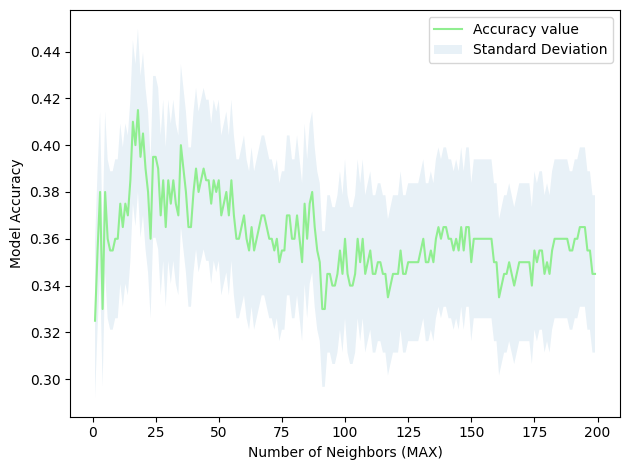

In [0]:
max_neighbors = 100{}
acc = np.zeros((max_neighbors -1))
std_acc = np.zeros((max_neighbors -1))

for n in range(1, max_neighbors):
    # Train Model and Predict
    # Create a model object
    # Create a model object
    KNN_n = KNeighborsClassifier(
        n_neighbors = n, 
        weights = 'uniform', 
        metric = 'cosine',
        algorithm = 'brute'
    )  
    # Train the model in the training data
    KNN_n.fit(X_train, y_train)

    # Predict the target variable in the test data
    y_pred = KNN_n.predict(X_test)

    # Metrics
    acc[n -1] = accuracy_score(y_test, y_pred)
    std_acc[n -1] = np.std(y_pred == y_test ) / np.sqrt(y_pred.shape[0])


# Plot Metrics
plt.plot(range(1, max_neighbors), acc, 'lightgreen')
plt.fill_between(range(1, max_neighbors), acc -1 * std_acc, acc + 1 * std_acc, alpha = 0.10)

plt.legend(('Accuracy value', 'Standard Deviation'))
plt.ylabel('Model Accuracy')
plt.xlabel('Number of Neighbors (MAX)')
plt.tight_layout()
plt.show()

In [0]:
print( 'The best accuracy was with', acc.max(), 'With Neighbors =', acc.argmax()+1)

The best accuracy was with 0.415 With Neighbors = 18


#### Retraining the model with the number of 18 neighbors

In [0]:
# Create a model object
KNN = KNeighborsClassifier(
    n_neighbors = 18, 
    weights = 'uniform', 
    metric = 'cosine', 
    algorithm = 'brute'
)

# Train the model in the training data
KNN.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",18
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'brute'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'cosine'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [0]:
# Predict the target variable in the test data
y_pred = KNN.predict(X_test)
# Collecting the probabilities of the model classifications
y_prob = KNN.predict_proba(X_test)

Accuracy: 0.41
AUC-ROC: 0.66


### Model Evaluation

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.36      0.65      0.46        46
           2       0.50      0.28      0.36        60
           3       0.46      0.46      0.46        56
           4       0.40      0.26      0.32        38

    accuracy                           0.41       200
   macro avg       0.43      0.42      0.40       200
weighted avg       0.44      0.41      0.40       200



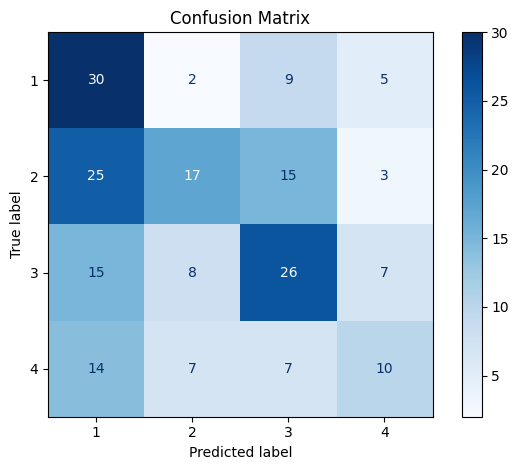

In [0]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels = ['1', '2', '3', '4'], 
    cmap = 'Blues', 
    values_format = 'd'
)

plt.grid(False) 
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [0]:
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'AUC-ROC: {roc_auc_score(y_test, y_prob, multi_class = 'ovr'):.2f}')

Accuracy: 0.41
AUC-ROC: 0.66


### Conclusion

---

- The KNN model relies entirely on the raw feature space at inference time. If the features do no provide clear boundaries between classes, KNN model cannot compensate through optimization or feature transformation.

- For a high number of weakly correlated features, the number of dimensions increases, the distance between points tend to become more uniform, reducing the discriminative power of KNN.

- The algorithm treats all features equally when computing distances. Hence, weakly correalted features can introduce noise or irrelevant variations in the feature space making it harder for KNN to find meaningful neighbours.

- The developed **K-Nearest Neighbors (KNN)** model demonstrates moderate predictive capacity with distinct performance tiers across customer groups. With an overall **Accuracy of 41%**, the model performs significantly better than a random guess (which would be 25% for 4 classes), but the **Area Under the Curve (AUC-ROC) of 0.66** indicates that the classifier has limited ability to clearly distinguish between the four service categories in the current feature space.

- The **Macro Average F1-Score of 0.40** reflects the unbalanced performance. While the model acts as a reasonable filter for identifying **Basic Service** users (acting as a "safe bet"), it lacks the specificity required to autonomously target **Total Service** (Class 4) customers without a high rate of missed opportunities (False Negatives). Further feature engineering or a different algorithm (like Random Forest) might be required to capture the non-linear complexity of high-value customers.